<a href="https://colab.research.google.com/github/mbosley/india_leg_text/blob/main/run_tbip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-Based Ideal Points
### ___Keyon Vafa, Suresh Naidu, David Blei___

**IMPORTANT:** To save this code and your results, make sure you copy to your personal Google Drive. Under "File", select "Save a copy in Drive".

Use this Colab notebook to run a Tensorflow implementation of the [text-based ideal point model (TBIP)](https://www.aclweb.org/anthology/2020.acl-main.475/) on a corpus of political text. Our [Github is more complete](https://github.com/keyonvafa/tbip), and it has code that can be used to reproduce all of our experiments. However, the TBIP is fastest on GPU, so if you do not have access to a GPU you can use Colab's GPUs for free. 

_Last updated: May 28, 2020_

The [TBIP](https://www.aclweb.org/anthology/2020.acl-main.475/) is an unsupervised probabilistic topic model that analyzes texts to quantify the political positions of its authors. The model does not use political parties or votes, nor does it require any text labelled by ideology. Given a corpus of political text and the authors of each document, the TBIP estimates the latent political positions of the authors of texts and how per-topic word choice changes as a function of the political position of the author ("ideological topics"). [Refer to our paper for more information](https://www.aclweb.org/anthology/2020.acl-main.475/).


The default corpus for this Colab notebook is [Senate speeches](https://data.stanford.edu/congress_text) from the 114th Senate session (2015-2017), but you can also upload your own data (we provide instructions below). [In our paper](https://www.aclweb.org/anthology/2020.acl-main.475/), we use the following corpora: Senate speeches, tweets from senators, and tweets from 2020 Democratic presidential candidates. 



## Getting started

First, **make sure you are running this Colab using a GPU**. Go to the "Runtime" menu, and click "Change runtime type". If the "Hardware accelerator" is listed as "None" or "TPU", change to "GPU". Click "Save" and you're ready to go. Also, as described in the first cell, make sure this code is copied to your personal Google Drive.

## Dependency imports

We start with dependency imports. Our code uses Tensorflow 1.x and the Tensorflow Probability library.

In [1]:
import functools
import time
import os

%tensorflow_version 1.x
import numpy as np
import scipy.sparse as sparse
from sklearn.decomposition import NMF
import tensorflow as tf
import tensorflow_probability as tfp

TensorFlow 1.x selected.


Below we clone our [Github repo for the TBIP](https://github.com/keyonvafa/tbip). The main inference code lives in this repo, as does the Senate speeches corpus.

In [2]:
! git clone https://github.com/keyonvafa/tbip
import tbip.tbip as tbip

fatal: destination path 'tbip' already exists and is not an empty directory.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.7
Requires: wrapt, wheel, astor, opt-einsum, google-pasta, tensorboard, keras-preprocessing, absl-py, protobuf, tensorflow-estimator, gast, termcolor, grpcio, keras-applications, six, numpy
Required-by: stable-baselines, magenta, fancyimpute


## Hyperparameters and Initialization

We start setting some hyperparameters. We fix the number of topics $K = 50$. We also set a random seed for reproducibility.

In [4]:
num_topics = 50
tf.set_random_seed(0)
random_state = np.random.RandomState(0)

The next cell provides the data directory. The directory in the cell below links to speeches from the 114th Senate session from the `tbip` repo.

To use your own corpus, upload the following four files to the Colab working directory:

* `counts.npz`: a `[num_documents, num_words]` [sparse CSR matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) containing the word counts for each document.
* `author_indices.npy`: a `[num_documents]` vector where each entry is an integer in the set `{0, 1, ..., num_authors - 1}`, indicating the author of the corresponding document in `counts.npz`.
* `vocabulary.txt`: a `[num_words]`-length file where each line denotes the corresponding word in the vocabulary.
* `author_map.txt`: a `[num_authors]`-length file where each line denotes the name of an author in the corpus.

See [Senate speech clean data](https://github.com/keyonvafa/tbip/tree/master/data/senate-speeches-114/clean) for an example of what the four files look like for Senate speeches. [Our setup script](https://github.com/keyonvafa/tbip/blob/master/setup/senate_speeches_to_bag_of_words.py) 
contains example code for creating the four files from unprocessed data for Senate speeches.

**IMPORTANT:** If you are using your own corpus, change the following line to `data_dir = '.'` after uploading the four files to the Colab working directory.


In [5]:
#data_dir = 'tbip/data/senate-speeches-114/clean'
data_dir = 'drive/Shareddrives/India Legislative Text/tbip'

[In our paper](https://www.aclweb.org/anthology/2020.acl-main.475/), we pre-initialize the parameters $\theta$ and $\beta$ with [Poisson factorization](https://arxiv.org/abs/1311.1704). Most of the time, we find this doesn't make a big difference for the learned ideal points, but it helps us interpret the ideological topics. 

Below, we initialize with Scikit-Learn's non-negative matrix factorization (NMF) implementation. Although we find that Poisson factorization learns more interpretable topics, we use Scikit-Learn's NMF implementation here because it is faster. To use Poisson factorization, see our [code in the Github repo](https://github.com/keyonvafa/tbip/blob/master/setup/poisson_factorization.py). 

If you would like to skip this pre-initialization step, set `pre_initialize_parameters = False` in the cell below. (Pre-initialization is recommended.)

In [6]:
pre_initialize_parameters = True

If you are pre-initializing parameters, the following cell might take a minute or so.

In [7]:
counts = sparse.load_npz(os.path.join(data_dir, 'counts.npz'))
num_documents, num_words = counts.shape
if pre_initialize_parameters:
  nmf_model = NMF(n_components=num_topics, 
                  init='random', 
                  random_state=0, 
                  max_iter=500)
  # Add offset to make sure none are zero.
  initial_document_loc = np.float32(nmf_model.fit_transform(counts) + 1e-3)
  initial_objective_topic_loc = np.float32(nmf_model.components_ + 1e-3)

else:
  initial_document_loc = np.float32(
      np.exp(random_state.randn(num_documents, num_topics)))
  initial_objective_topic_loc = np.float32(
      np.exp(random_state.randn(num_topics, num_words)))

## Create Iterator for Training

Below we build our input pipeline for training. We train with data subsampling. We set a batch size of 512; we recommend to use the largest batch size that fits in memory. After we create the input pipeline, `counts` is the `[batch_size, num_words]` tensor representing word counts for each document, `document_indices` is the `[batch_size]` tensor of integers representing the indices of each document in the batch, and `author_indices` is the `[batch_size]` tensor of integers representing the indices of each author in the batch.

In [8]:
batch_size = 512
(iterator, author_weights, vocabulary, author_map, 
 num_documents, num_words, num_authors) = tbip.build_input_pipeline(
      data_dir, 
      batch_size,
      random_state,
      counts_transformation='nothing')
document_indices, counts, author_indices = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


## Perform Inference

We perform inference using [variational inference](https://arxiv.org/abs/1601.00670) with [reparameterization](https://arxiv.org/abs/1312.6114) [gradients](https://arxiv.org/abs/1401.4082). We provide a brief summary below, but encourage readers to [refer to our paper](https://www.aclweb.org/anthology/2020.acl-main.475/) for a more complete overview.

It is intractable to evaluate the posterior distribution $p(\theta, \beta, \eta, x | y)$, so we approximate the posterior with a distribution $q_\phi(\theta, \beta,\eta,x)$, parameterized by $\phi$. How do we set the values $\phi$? We want to minimize the KL-Divergence between $q$ and the posterior, which is equivalent to maximizing the ELBO:
$$\mathbb{E}_{q_\phi}[\log p(y, \theta, \beta, \eta, x) - \log q_{\phi}(\theta, \beta, \eta, x)].$$
We set the variational family to be the mean-field family, meaning the latent variables factorize over documents $d$, topics $k$, and authors $s$:
$$q_\phi(\theta, \beta, \eta, x) = \prod_{d,k,s} q(\theta_d)q(\beta_k)q(\eta_k)q(x_s).$$
We use lognormal factors for the positive variables and Gaussian factors for the real variables:
$$q(\theta_d) = \text{LogNormal}_K(\mu_{\theta_d}\sigma^2_{\theta_d})$$
$$q(\theta_d) = \text{LogNormal}_V(\mu_{\beta_k}, \sigma^2_{\beta_k})$$
$$q(\eta_k) = \mathcal{N}_V(\mu_{\eta_k}, \sigma^2_{\eta_k})$$
$$q(x_s) = \mathcal{N}(\mu_{x_s}, \sigma^2_{x_s}).$$

Thus, our goal is to maximize the ELBO with respect to $\phi = \{\mu_\theta, \sigma_\theta, \mu_\beta, \sigma_\beta,\mu_\eta, \sigma_\eta, \mu_x, \sigma_x\}$. 

In the cells below, we initialize the variational parameters $\phi$ and their respective variational distributions. We use `loc` to name the location variables $\mu$, and `scale` to name the scale variables $\sigma$. So, $\mu_\eta$ is denoted by `ideological_topic_loc` and $\sigma_\eta$ is denoted by `ideological_topic_scale`, etc. Its corresponding variational distribution is `ideological_topic_distribution`.

In [9]:
# Create Lognormal variational family for document intensities (theta).
document_loc = tf.get_variable(
    "document_loc",
    initializer=tf.constant(np.log(initial_document_loc)))
document_scale_logit = tf.get_variable(
    "document_scale_logit",
    shape=[num_documents, num_topics],
    initializer=tf.initializers.random_normal(mean=-2, stddev=1.),
    dtype=tf.float32)
document_scale = tf.nn.softplus(document_scale_logit)
document_distribution = tfp.distributions.LogNormal(
    loc=document_loc,
    scale=document_scale) 

# Create Lognormal variational family for objective topics (beta).
objective_topic_loc = tf.get_variable(
    "objective_topic_loc",
    initializer=tf.constant(np.log(initial_objective_topic_loc)))
objective_topic_scale_logit = tf.get_variable(
    "objective_topic_scale_logit",
    shape=[num_topics, num_words],
    initializer=tf.initializers.random_normal(mean=-2, stddev=1.),
    dtype=tf.float32)
objective_topic_scale = tf.nn.softplus(objective_topic_scale_logit)
objective_topic_distribution = tfp.distributions.LogNormal(
    loc=objective_topic_loc,
    scale=objective_topic_scale)
  
# Create Gaussian variational family for ideological topics (eta).
ideological_topic_loc = tf.get_variable(
    "ideological_topic_loc",
    shape=[num_topics, num_words],
    dtype=tf.float32)
ideological_topic_scale_logit = tf.get_variable(
    "ideological_topic_scale_logit",
    shape=[num_topics, num_words],
    dtype=tf.float32)
ideological_topic_scale = tf.nn.softplus(ideological_topic_scale_logit)
ideological_topic_distribution = tfp.distributions.Normal(
    loc=ideological_topic_loc,
    scale=ideological_topic_scale)

# Create Gaussian variational family for ideal points (x).
ideal_point_loc = tf.get_variable(
    "ideal_point_loc",
    shape=[num_authors],
    dtype=tf.float32)
ideal_point_scale_logit = tf.get_variable(
    "ideal_point_scale_logit",
    initializer=tf.initializers.random_normal(mean=0, stddev=1.),
    shape=[num_authors],
    dtype=tf.float32)
ideal_point_scale = tf.nn.softplus(ideal_point_scale_logit)
ideal_point_distribution = tfp.distributions.Normal(
    loc=ideal_point_loc,
    scale=ideal_point_scale)

# Approximate ELBO.
elbo = tbip.get_elbo(counts,
                     document_indices,
                     author_indices,
                     author_weights,
                     document_distribution,
                     objective_topic_distribution,
                     ideological_topic_distribution,
                     ideal_point_distribution,
                     num_documents,
                     batch_size)
loss = -elbo

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Optimize

We train using the Adam optimizer. To change the learning rate, change the value of `learning_rate` below.

The tensors `neutral_mean`, `positive_mean`, and `negative_mean` provide ideological topics for the topics under discussion in the corpus. `neutral_mean` contains the topic estimates for an author $s$ with an ideal point $x_s=0$, `positive_mean` contains the topics for an author $s$ with an ideal point $x_s = 1$, and `negative_mean` contains the topics for an author $s$ with an ideal point $x_s = -1$. We print these topics as we train.

In [10]:
learning_rate = 0.01
optim = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optim.minimize(loss)

neutral_mean = objective_topic_loc + objective_topic_scale ** 2 / 2
positive_mean = (objective_topic_loc + 
                 ideological_topic_loc + 
                 (objective_topic_scale ** 2 + 
                  ideological_topic_scale ** 2) / 2)
negative_mean = (objective_topic_loc - 
                 ideological_topic_loc +
                 (objective_topic_scale ** 2 + 
                  ideological_topic_scale ** 2) / 2)

In [11]:
#@title Run this cell to create helper functions for printing topics and ordered ideal points

def get_topics(neutral_mean, 
               negative_mean, 
               positive_mean, 
               vocabulary, 
               print_to_terminal=True):
  num_topics, num_words = neutral_mean.shape
  words_per_topic = 10
  top_neutral_words = np.argsort(-neutral_mean, axis=1)
  top_negative_words = np.argsort(-negative_mean, axis=1)
  top_positive_words = np.argsort(-positive_mean, axis=1)
  topic_strings = []
  for topic_idx in range(num_topics):
    neutral_start_string = "Neutral  {}:".format(topic_idx)
    neutral_row = [vocabulary[word] for word in 
                    top_neutral_words[topic_idx, :words_per_topic]]
    neutral_row_string = ", ".join(neutral_row)
    neutral_string = " ".join([neutral_start_string, neutral_row_string])
    
    positive_start_string = "Positive {}:".format(topic_idx)
    positive_row = [vocabulary[word] for word in 
                    top_positive_words[topic_idx, :words_per_topic]]
    positive_row_string = ", ".join(positive_row)
    positive_string = " ".join([positive_start_string, positive_row_string])
    
    negative_start_string = "Negative {}:".format(topic_idx)
    negative_row = [vocabulary[word] for word in 
                    top_negative_words[topic_idx, :words_per_topic]]
    negative_row_string = ", ".join(negative_row)
    negative_string = " ".join([negative_start_string, negative_row_string])
    
    if print_to_terminal:
      topic_strings.append(negative_string)
      topic_strings.append(neutral_string)
      topic_strings.append(positive_string)
      topic_strings.append("==========")
    else:
      topic_strings.append("  \n".join(
        [negative_string, neutral_string, positive_string]))
  
  if print_to_terminal:
    all_topics = "{}\n".format(np.array(topic_strings))
  else:
    all_topics = np.array(topic_strings)
  return all_topics


def get_ideal_points(ideal_point_loc, author_map, print_to_terminal=True):
  """Print ideal point ordering for Tensorboard."""
  if print_to_terminal:
    offset = 5
    sorted_authors = author_map[np.argsort(ideal_point_loc)]
    authors_by_line = [", ".join(sorted_authors[i * offset:i*offset+offset]) 
                       for i in range((len(author_map) - 1) // offset + 1)]
    sorted_list = ("Sorted ideal points:"
        "\n ==================== \n{}"
        "\n ==================== ".format(",\n".join(authors_by_line)))
  else:
    sorted_list = ", ".join(author_map[np.argsort(ideal_point_loc)])
  
  return sorted_list

## Execute Training

The code above was creating the graph; below we actually run training. You can adjust the number of steps to train (`max_steps`) and the frequency at which to print the ELBO (`print_steps`) in the cell below. 

In [12]:
max_steps = 50000
print_steps = 100

Here, we run our training loop. Topic summaries and ordered ideal points will print every 2500 steps. Typically in our experiments it takes 15,000 steps or so to begin seeing sensible results, but of course this depends on the corpus. These sensible results should be reached within a half hour. For the default corpus of Senate speeches, it should take less than 2 hours to complete the full 50,000 training steps. 

**NOTE:** You may see a RAM error while training. This is fine; the script should finish training. Although you will lose all local variables, parameters are saved while training. To access these parameters, restart the notebook when training is finished and jump to the section "Analyze Results"

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
start_time = time.time()
for step in range(max_steps):
  (_, elbo_val) = sess.run([train_op, elbo])
  duration = (time.time() - start_time) / (step + 1)
  if step % print_steps == 0 or step == max_steps - 1:
    print("Step: {:>3d} ELBO: {:.3f} ({:.3f} sec/step)".format(
        step, elbo_val, duration))
  if (step + 1) % 2500 == 0 or step == max_steps - 1:
    (neutral_topic_mean, negative_topic_mean, positive_topic_mean, 
     ideal_point_mean) = sess.run([neutral_mean, negative_mean, 
                                   positive_mean, ideal_point_loc])
    print(get_topics(neutral_topic_mean, 
                     negative_topic_mean, 
                     positive_topic_mean, 
                     vocabulary))
    print(get_ideal_points(ideal_point_mean, author_map))
    np.save("neutral_topic_mean.npy", neutral_topic_mean)
    np.save("negative_topic_mean.npy", negative_topic_mean)
    np.save("positive_topic_mean.npy", positive_topic_mean)
    np.save("ideal_point_mean.npy", ideal_point_mean)

Step:   0 ELBO: -7223067.000 (1.020 sec/step)
Step: 100 ELBO: -3013403.500 (0.126 sec/step)
Step: 200 ELBO: -2642678.000 (0.121 sec/step)
Step: 300 ELBO: -2423500.000 (0.120 sec/step)
Step: 400 ELBO: -2309138.500 (0.119 sec/step)
Step: 500 ELBO: -2330989.250 (0.119 sec/step)
Step: 600 ELBO: -2203040.500 (0.118 sec/step)
Step: 700 ELBO: -2352753.000 (0.118 sec/step)
Step: 800 ELBO: -2144931.250 (0.118 sec/step)
Step: 900 ELBO: -2422028.500 (0.118 sec/step)
Step: 1000 ELBO: -2366640.500 (0.117 sec/step)
Step: 1100 ELBO: -2196074.500 (0.117 sec/step)
Step: 1200 ELBO: -2199935.000 (0.117 sec/step)
Step: 1300 ELBO: -2145325.500 (0.117 sec/step)
Step: 1400 ELBO: -2128626.500 (0.117 sec/step)
Step: 1500 ELBO: -2146247.000 (0.117 sec/step)
Step: 1600 ELBO: -2311731.750 (0.117 sec/step)
Step: 1700 ELBO: -2225383.750 (0.117 sec/step)
Step: 1800 ELBO: -2068619.875 (0.117 sec/step)
Step: 1900 ELBO: -2116999.000 (0.117 sec/step)
Step: 2000 ELBO: -2113161.500 (0.117 sec/step)
Step: 2100 ELBO: -21891

## Analyze Results

**NOTE:** Even if running the TBIP training results in a RAM error, you can start right at this cell since the results are saved.

Below we load the ideal points and ideological topics.

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import Series

ideal_point_mean = np.load("ideal_point_mean.npy")
neutral_topic_mean = np.load("neutral_topic_mean.npy")
negative_topic_mean = np.load("negative_topic_mean.npy")
positive_topic_mean = np.load("positive_topic_mean.npy")

Now we load our list of authors. If you used your own corpus, change the following line to `data_dir = '.'`.

In [17]:
data_dir = 'drive/Shareddrives/India Legislative Text/tbip'
author_map = np.loadtxt(os.path.join(data_dir, 'author_map.txt'), 
                        dtype=str, 
                        delimiter='\n', 
                        comments='//')

For example, here is a graph of the learned ideal points. We don't label each point because there are too many to plot. Below we select some authors to label.

In [19]:
selected_authors = np.array([])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


[]

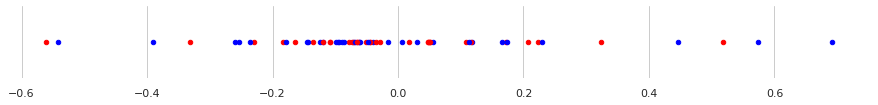

In [47]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12, 1))
ax = plt.axes([0, 0, 1, 1], frameon=False)
elected_author_idx = [ind for ind, x in enumerate(author_map) if '(1)' in x]
unelected_author_idx = [ind for ind, x in enumerate(author_map) if '(0)' in x]


for index in range(len(elected_author_map)):
    if index in elected_author_idx:
        ax.scatter(ideal_point_mean[index], 0, c='blue', s=20)
    elif index in unelected_author_idx:
        ax.scatter(ideal_point_mean[index], 0, c='red', s=20)

    if author_map[index] in selected_authors:
        ax.annotate(author_map[index], xy=(ideal_point_mean[index], 0.), 
                    xytext=(ideal_point_mean[index], 0), rotation=30, size=14)
      
ax.set_yticks([])

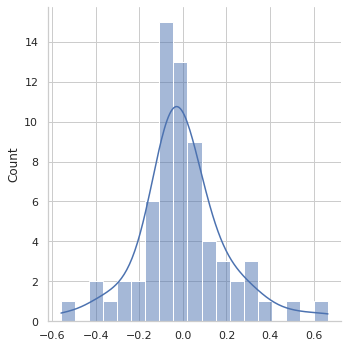

In [66]:
sns.displot([x for ind, x in enumerate(ideal_point_mean) if ind in unelected_author_idx], kde=True)
#sns.displot([x for ind, x in enumerate(ideal_point_mean) if ind in unelected_author_idx], c = "red", kind="kde", bw_adjust=.25)

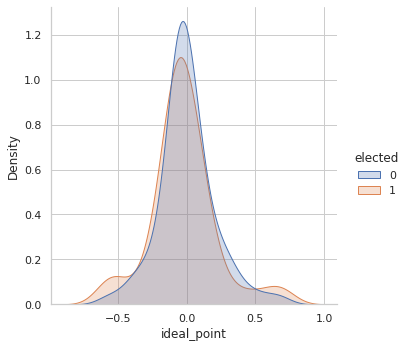

In [78]:
df = pd.DataFrame({'speaker': author_map, 'ideal_point': ideal_point_mean})
df["elected"] = [0 if '(0)' in x else 1 for x in df['speaker']]

sns.displot(df, x="ideal_point", hue="elected", kind="kde", fill=True)